In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# loading the Iris data set in to the data variable.
data = load_iris()

# Convert the NumPy feature matrix shape: 150 x 4 to a pandas DataFrame
x = pd.DataFrame(data.data, columns = data.feature_names)   # The features

# Convert the label shape 150 to a pandas Series.
# Values are integer class IDs: 0 = setosa, 1 = versicolor, 2 = virginica.
y = pd.Series(data.target, name = 'target') # The labels

# Targe names for the y axis
target_names = data.target_names

# 5 number of rows
print(x.head())

# Show the class names in the order they map to y's integers
print(target_names)

# Split into training and test sets.
# test_size = 0.2 = 20% using 30 samples for testing; 80% using 120 samples for training
# random_state = 42: ensures the split is reproducible across runs
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

# from the remaining 80% (x_train/y_train), take 25% for validation
# Resulting proportions: 60% train, 20% value, 20% test.
x_train, x_value, y_train, y_value = train_test_split(x_train, y_train, test_size = 0.25, random_state=42, stratify = y_train)

# print train, value and test size
print(f"Train size: {len(x_train)}, Value size: {len(x_value)}, Test size: {len(x_test)}")


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
['setosa' 'versicolor' 'virginica']
Train size: 90, Value size: 30, Test size: 30


In [ ]:
# Fit a baseline decision tree on the training dataset
baseline_tree = DecisionTreeClassifier(random_state = 42)

# Train the model on the training split.
baseline_tree.fit(x_train, y_train)

# Predict the class labels for the validation set to estimate sample performance.
value_baseline = baseline_tree.predict(x_value)

# Accuracy on the validation set
baseline_value_accuracy = accuracy_score(y_value, value_baseline)

print(f"Baseline validation accuracy: {baseline_value_accuracy:.3f}")

Baseline validation accuracy: 0.933


In [ ]:
# Define the hyperparameter grids to explore:
# max_depth: how deep the tree can grow
# min_samples_leaf: minimum samples required at a leaf node
max_depth_grid = list(range(1, 16))
min_leaf_grid  = [1, 2, 3, 4, 5, 8, 10]

# Storage for results
results = []  # max_depth, min_samples_leaf, validation_accuracy

# A convenience matrix to hold accuracies in grid form for plotting and inspection
# Rows correspond to min_leaf_grid, columns to max_depth_grid.
accuracy_matrix = np.zeros((len(min_leaf_grid), len(max_depth_grid)))

# Grid search over all (max_depth, min_samples_leaf) combinations
for i, mleaf in enumerate(min_leaf_grid):
    for j, mdepth in enumerate(max_depth_grid):
        # Create a Decision Tree with the current hyperparameters
        clf = DecisionTreeClassifier(
            random_state = 42,
            max_depth = mdepth,
            min_samples_leaf = mleaf
        )

        # Fit on the training data
        clf.fit(x_train, y_train)

        # Predict on the validation set
        value_pred = clf.predict(x_value)

        # Compute validation accuracy for this combo
        accuracy = accuracy_score(y_value, value_pred)

        # Record results
        results.append((mdepth, mleaf, accuracy))
        accuracy_matrix[i, j] = accuracy

# Convert results to a DataFrame
grid_df = pd.DataFrame(results, columns = ["max_depth", "min_samples_leaf", "value_accuracy"])

# Make a pivoted view: rows=min_samples_leaf, columns=max_depth, values=accuracy
grid_df_pivot = grid_df.pivot(
    index = "min_samples_leaf",
    columns = "max_depth",
    values = "value_accuracy"
)

# Peek at the first 5 rows
grid_df.head()

,max_depth,min_samples_leaf,value_accuracy
0,1,1,0.666667
1,2,1,0.900000
2,3,1,0.900000
3,4,1,0.933333
4,5,1,0.933333


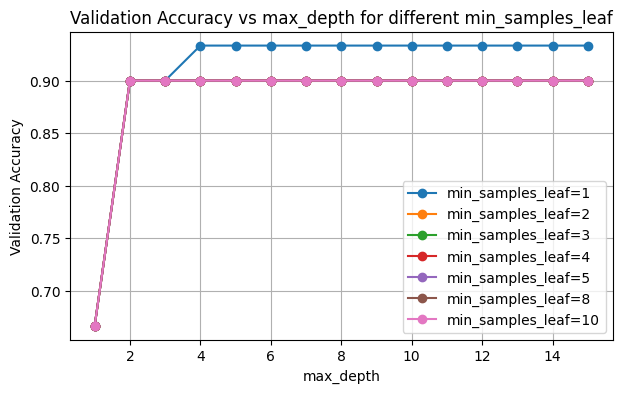

In [ ]:
# Plot 1: Accuracy vs max_depth for each min_samples_leaf
plt.figure(figsize=(7,4))
for i, mleaf in enumerate(min_leaf_grid):
    plt.plot(max_depth_grid, accuracy_matrix[i, :], marker='o', label=f"min_samples_leaf={mleaf}")
plt.xlabel("max_depth")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs max_depth for different min_samples_leaf")
plt.legend()
plt.grid(True)
plt.show()


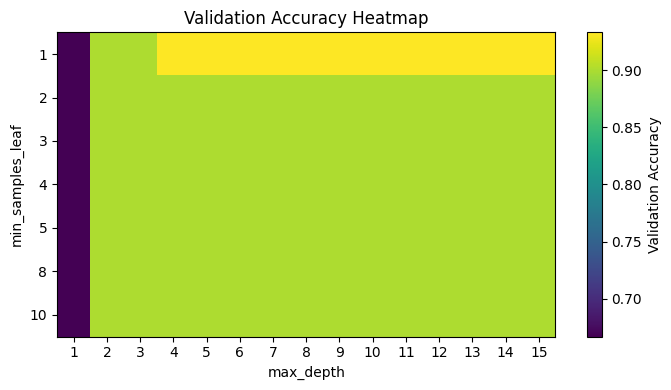

In [ ]:
# Plot 2: Heatmap of validation accuracy across the grid
plt.figure(figsize=(7,4))
plt.imshow(accuracy_matrix, aspect='auto', interpolation='nearest')
plt.colorbar(label = "Validation Accuracy")
plt.xticks(ticks = range(len(max_depth_grid)), labels = max_depth_grid, rotation=0)
plt.yticks(ticks = range(len(min_leaf_grid)), labels = min_leaf_grid)
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
plt.title("Validation Accuracy Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameters by highest validation accuracy
best_row = grid_df.sort_values(
    by=["value_accuracy","max_depth","min_samples_leaf"],
    ascending=[False, True, True]
).iloc[0]

best_max_depth = int(best_row["max_depth"])
best_min_leaf = int(best_row["min_samples_leaf"])
best_val_acc = float(best_row["value_accuracy"])

print(f"Best params -> max_depth = {best_max_depth}, min_samples_leaf = {best_min_leaf}")
print(f"Best validation accuracy: {best_val_acc:.3f}")

Best params -> max_depth = 4, min_samples_leaf = 1
Best validation accuracy: 0.933


In [ ]:
# Training model Combining the training and validation splits to maximize the data used for fitting
x_train_full = pd.concat([x_train, x_value], axis=0)
y_train_full = pd.concat([y_train, y_value], axis=0)

# Instantiate the final Decision Tree with the tuned hyperparameters
final_tree = DecisionTreeClassifier(
    random_state = 42, # reproducibility
    max_depth = best_max_depth, # depth selected from validation search
    min_samples_leaf = best_min_leaf # leaf size selected from validation search
)

# Fit the final model on the combined data
final_tree.fit(x_train_full, y_train_full)

# Predict on the untouched test set to get an unbiased estimate of performance
test_pred = final_tree.predict(x_test)

# Compute and print test accuracy
test_acc = accuracy_score(y_test, test_pred)
print(f"Test accuracy: {test_acc:.3f}\n")

print("Classification report (test):")
print(classification_report(y_test, test_pred, target_names = target_names))

Test accuracy: 0.933

Classification report (test):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



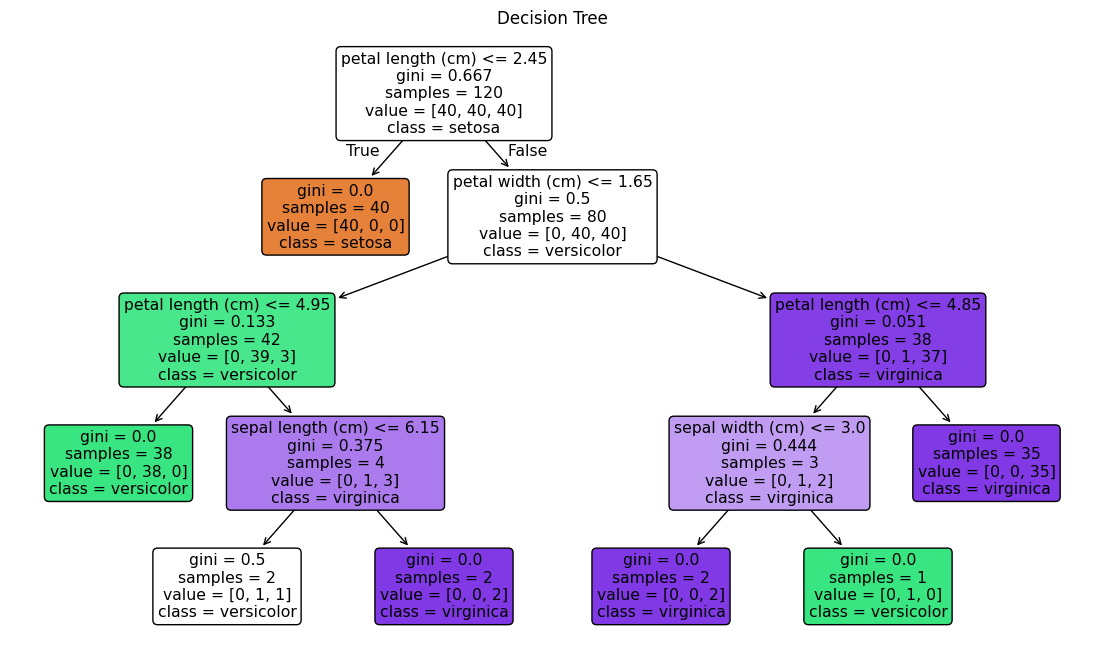

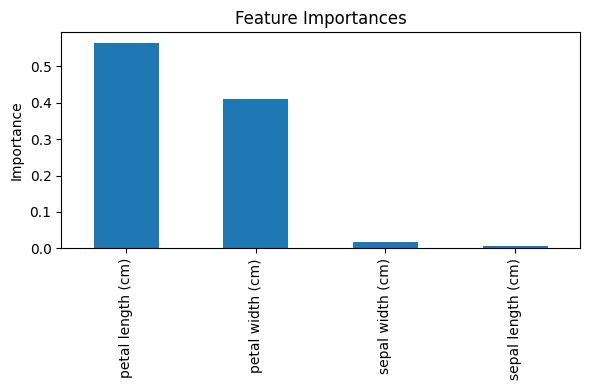

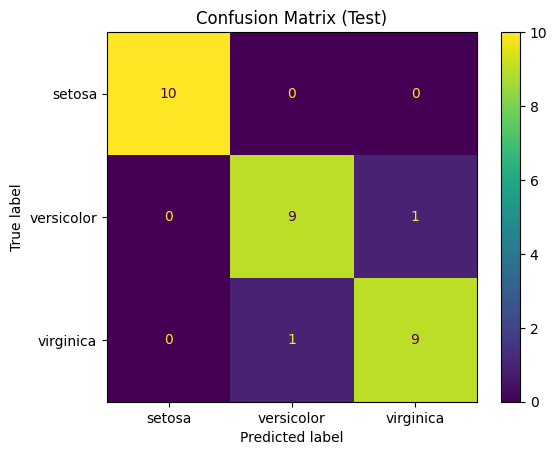

In [ ]:
# Plot the tree
plt.figure(figsize = (14, 8))
plot_tree(
    final_tree,
    feature_names = x.columns,
    class_names = target_names,
    filled = True,
    rounded = True
)
plt.title("Decision Tree")
plt.show()

# Feature importances
importances = pd.Series(final_tree.feature_importances_, index = x.columns).sort_values(ascending = False)
plt.figure(figsize = (6,4))
importances.plot(kind = 'bar')
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Confusion matrix on test
disp = ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels = target_names)
plt.title("Confusion Matrix (Test)")
plt.show()